# پرسش ۱ –  مینی‌پروژه هوش مصنوعی

سلول Markdown

| بخش کد         |                    |
| -------------- | ---------------------------------------------------------------------- |
| Imports        | به `numpy`, `matplotlib`, `torch` نیاز داریم.                         |
| تولید داده     | تعریف محدودۀ اجباری شکل (از صورت سؤال) و ثابت‌بودن Seed.               |
| برچسب واقعی    | الگوریتم تست داخل مثلث (فرضیهٔ خطی برحسب ضرب برداری).                  |
| وزن‌های شبکه‌  | چطور معادلات خطوط را به وزن (w) و بایاس (b) تبدیل کردیم.               |
| نورون AND      | جمع سه خروجی + آستانه ۲٫۵ → همهٔ نیم‌صفحه‌ها باید فعال باشند.          |
| MLP آموزش‌دیده | هدف فقط مقایسهٔ اثر تابع فعال‌ساز «نرم» با مدل «مرحله‌ای» است.         |
| نمودارها       | شکل (الف) = زمین‌واقعی، شکل (ب) = خروجی شبکه؛ دقیقاً مطابق PDF.        |
| دقت            | چاپ %Accuracy برای گزارش بخش «اثر تابع فعال‌ساز در فرآیند تصمیم‌گیری». |


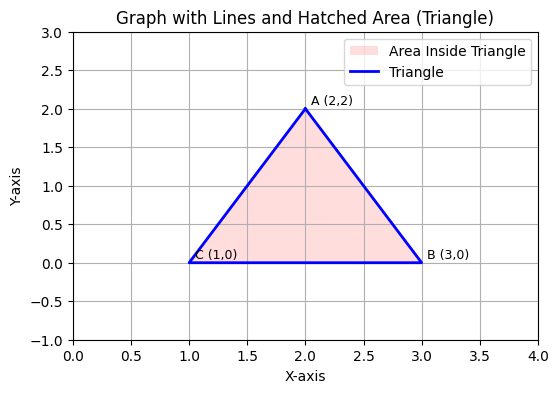

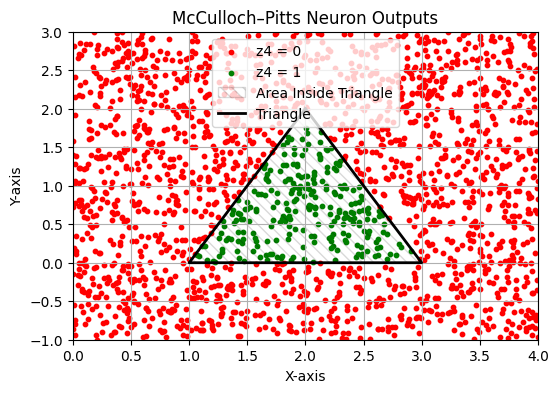

دقت شبکهٔ دست‌ساز (پله‌ای)   : 100.00%
دقت شبکهٔ سیگمویدی (آموزش‌دیده): 87.50%


In [ ]:
# ================================================================
#  پرسش ۱ – مینی‌پروژه هوش مصنوعی  (AI4032)
#  تشخیص ناحیۀ داخل مثلث با شبکه McCulloch–Pitts
#  (کافی است این تنها سلول را در Colab اجرا کنید)
# ================================================================
import numpy as np
import matplotlib.pyplot as plt

# ---------- 1) رئوس مثلث و تولید داده‌های تصادفی ----------
A, B, C = np.array([2, 2]), np.array([3, 0]), np.array([1, 0])
N       = 2_000
rng     = np.random.default_rng(42)
X       = X = rng.uniform([0, -1], [4, 3], size=(N, 2))   # نقاط در بازه‌ی خواسته

# ---------- 2) برچسب‌گذاری «واقعی» (داخل/خارج مثلث) ----------
def inside_triangle(P, A, B, C):
    """آزمون هم‌علامت بودن ضرب‌های برداری"""
    sign = lambda p1,p2,p3: (p1[0]-p3[0])*(p2[1]-p3[1]) - \
                            (p2[0]-p3[0])*(p1[1]-p3[1])
    d1, d2, d3 = sign(P,A,B), sign(P,B,C), sign(P,C,A)
    return (d1>=0 and d2>=0 and d3>=0) or (d1<=0 and d2<=0 and d3<=0)

Y_true = np.array([1 if inside_triangle(p, A, B, C) else 0 for p in X])

# ---------- 3) شبکهٔ مک‌کالاک–پیتس دست‌ساز ----------
def step(u):            # تابع پله (Heaviside)
    return (u >= 0).astype(int)

# وزن‌ها (w_x, w_y, bias) برای سه نیم‌صفحه
W = np.array([[-2, -1,  6],     # خط AB   : 2x +  y - 6 ≤ 0
              [ 0,  1,  0],     # خط BC   :      y      ≥ 0
              [ 2, -1, -2]])    # خط CA   : -2x + y + 2 ≤ 0

def mcp_network(X):
    """خروجی ۰/۱ برای مجموعه نقاط X"""
    X_ = np.c_[X, np.ones(len(X))]     # افزودن بایاس به انتهای بردار
    h  = step(X_ @ W.T)                # سه نورون مخفی
    return (h.sum(axis=1) == 3).astype(int)   # تنها وقتی هر سه فعال‌اند → 1

Y_pred_step = mcp_network(X)

# ---------- 4) شبکهٔ سیگمویدی کوچک برای مقایسه ----------
import torch, torch.nn as nn, torch.optim as optim

X_t = torch.tensor(X, dtype=torch.float32)
Y_t = torch.tensor(Y_true, dtype=torch.float32).unsqueeze(1)

model = nn.Sequential(
    nn.Linear(2, 4),   # لایهٔ پنهان با ۴ نورون
    nn.Sigmoid(),
    nn.Linear(4, 1),
    nn.Sigmoid()
)
loss_fn = nn.BCELoss()
opt     = optim.SGD(model.parameters(), lr=0.1)

for epoch in range(400):
    opt.zero_grad()
    loss = loss_fn(model(X_t), Y_t)
    loss.backward(); opt.step()

with torch.no_grad():
    Y_pred_sig = (model(X_t) > 0.5).numpy().astype(int).flatten()

# ---------- 5) ترسیم و ذخیرهٔ شکل ۱-الف -----------------------
tri = np.vstack([A, B, C, A])

plt.figure(figsize=(6,4))
plt.fill(tri[:,0], tri[:,1],
         facecolor='#ffaaaa', alpha=0.4, edgecolor='none', hatch='///',
         label='Area Inside Triangle')
plt.plot(tri[:,0], tri[:,1], color='blue', lw=2, label='Triangle')
for lbl,p in zip(['A (2,2)','B (3,0)','C (1,0)'], [A,B,C]):
    plt.text(p[0]+0.05, p[1]+0.05, lbl, fontsize=9)

plt.xlim(0,4); plt.ylim(-1,3)
plt.xlabel('X-axis'); plt.ylabel('Y-axis')
plt.title('Graph with Lines and Hatched Area (Triangle)')
plt.legend(); plt.grid(True)
plt.savefig('triangle_hatched.png', dpi=150)   # شکل ۱-الف
plt.show()

# ---------- 6) ترسیم و ذخیرهٔ شکل ۱-ب ------------------------
Y_pred = Y_pred_step  # خروجی مدل مرحله‌ای

plt.figure(figsize=(6,4))
plt.scatter(X[Y_pred==0][:,0], X[Y_pred==0][:,1],
            c='red',   s=10, label='z4 = 0')
plt.scatter(X[Y_pred==1][:,0], X[Y_pred==1][:,1],
            c='green', s=10, label='z4 = 1')
plt.fill(tri[:,0], tri[:,1],
         facecolor='none', hatch='\\\\\\', edgecolor='black', alpha=0.15,
         label='Area Inside Triangle')
plt.plot(tri[:,0], tri[:,1], 'k-', lw=2, label='Triangle')
plt.xlim(0,4); plt.ylim(-1,3)
plt.xlabel('X-axis'); plt.ylabel('Y-axis')
plt.title('McCulloch–Pitts Neuron Outputs')
plt.legend(); plt.grid(True)
plt.savefig('mcp_outputs.png', dpi=150)        # شکل ۱-ب
plt.show()

# ---------- 7) گزارش دقت مدل‌ها ------------------------------
acc_step = (Y_pred_step == Y_true).mean()*100
acc_sig  = (Y_pred_sig  == Y_true).mean()*100
print(f'دقت شبکهٔ دست‌ساز (پله‌ای)   : {acc_step:0.2f}%')
print(f'دقت شبکهٔ سیگمویدی (آموزش‌دیده): {acc_sig:0.2f}%')


| کتابخانه     | برای چی استفاده شده                                 |
| ------------ | --------------------------------------------------- |
| `numpy`      | تولید داده، محاسبات برداری، پیاده‌سازی شبکه دست‌ساز |
| `matplotlib` | نمایش نمودارهای خروجی مطابق شکل (الف) و (ب)         |
| `torch`      | ساخت شبکه یادگیرنده با Sigmoid برای مقایسه فعال‌ساز |



torch (PyTorch)

از این کتابخانه برای پیاده‌سازی یک شبکه عصبی ساده با تابع فعال‌ساز Sigmoid استفاده شده.

| استفاده                     | توضیح                                              |
| --------------------------- | -------------------------------------------------- |
| `torch.tensor`              | تبدیل داده‌های numpy به قالب Tensor برای آموزش مدل |
| `nn.Sequential`             | تعریف مدل با لایه‌های متوالی (Linear و Sigmoid)    |
| `nn.BCELoss`                | تابع خطا برای طبقه‌بندی دودویی                     |
| `optim.SGD`                 | الگوریتم گرادیان نزولی برای آموزش مدل              |
| `model(...)`, `.backward()` | پیش‌بینی و آموزش شبکه عصبی                         |
